In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from time import time
from operator import itemgetter

import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve


In [2]:
titanic = sns.load_dataset("titanic")


In [3]:
headers = [c for c in titanic.columns]
headers.insert(0,"ID")
print tabulate(titanic[0:5], headers, tablefmt="pipe")

|   ID |   survived |   pclass | sex    |   age |   sibsp |   parch |    fare | embarked   | class   | who   |   adult_male | deck   | embark_town   | alive   |   alone |
|-----:|-----------:|---------:|:-------|------:|--------:|--------:|--------:|:-----------|:--------|:------|-------------:|:-------|:--------------|:--------|--------:|
|    0 |          0 |        3 | male   |    22 |       1 |       0 |  7.25   | S          | Third   | man   |            1 | nan    | Southampton   | no      |       0 |
|    1 |          1 |        1 | female |    38 |       1 |       0 | 71.2833 | C          | First   | woman |            0 | C      | Cherbourg     | yes     |       0 |
|    2 |          1 |        3 | female |    26 |       0 |       0 |  7.925  | S          | Third   | woman |            0 | nan    | Southampton   | yes     |       1 |
|    3 |          1 |        1 | female |    35 |       1 |       0 | 53.1    | S          | First   | woman |            0 | C      | Southampto

In [4]:
# 文字になっている列の種別をcategory変数に変更
titanic['embark_town'] = titanic.embark_town.map( {np.nan:0, 'Cherbourg':1, 'Queenstown':2, 'Southampton':3} ).astype(int)
titanic['deck'] = titanic.deck.map( {np.nan:0, 'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7} ).astype(int)
titanic['who'] = titanic.who.map( {"child":0, "man":1, "woman":2} ).astype(int)
titanic['class'] = titanic['class'].map( {"First":1, "Second":2, "Third":3} ).astype(int)
titanic['embarked'] = titanic.embarked.map( {np.nan:0, "S":1, "C":2, "Q":3 } ).astype(int)
titanic['sex'] = titanic.sex.map( {'female': 0, "male": 1} ).astype(int)
titanic['age'] = titanic.age.fillna(titanic.age.median())

## 訓練データとテストデータの作成

### ホールドアウト法

In [5]:
# 訓練データ(80%), テストデータ(20%)に分割する
target = titanic.ix[:, 0]
data = titanic.ix[:, [1,2,3,4,5,6,7,8,9,10,11,12,14]]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=None)

print [d.shape for d in [X_train, X_test, y_train, y_test]]

[(712, 13), (179, 13), (712,), (179,)]


In [6]:
# SVM(線形カーネル)で分類し、誤り率を算出
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print u"再代入誤り率：", 1 - clf.score(X_train, y_train)   
print u"ホールドアウト誤り率：", 1 - clf.score(X_test, y_test)   


再代入誤り率： 0.172752808989
ホールドアウト誤り率： 0.195530726257


In [7]:
# SVM(rbfカーネル)で分類し、誤り率を算出
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
print u"再代入誤り率：", 1 - clf.score(X_train, y_train)   
print u"ホールドアウト誤り率：", 1 - clf.score(X_test, y_test)   



再代入誤り率： 0.0786516853933
ホールドアウト誤り率： 0.284916201117


### KFold法

In [8]:
# KFold
# n_foldsで指定した数値でデータを分割。n_folds=5とした場合、5分割
# してそのうちの１つをテストデータとし、5通りパターンを生成する。
kf = KFold(30, n_folds=5,shuffle=False)
for tr, ts in kf:
    print("%s %s" % (tr, ts))

[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [0 1 2 3 4 5]
[ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [ 6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 18 19 20 21 22 23 24 25 26 27 28 29] [12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 24 25 26 27 28 29] [18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24 25 26 27 28 29]


In [9]:
# StratifiedKFold
# 各クラスごとの抽出率を元データの比率に合わせたKFoldの改良版

label = np.r_[np.repeat(0,20), np.repeat(1,10)]
skf = StratifiedKFold(label, n_folds=5, shuffle=False)
for tr, ts in skf:
    print("%s %s" % (tr, ts))

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 23 24 25 26 27 28 29] [ 0  1  2  3 20 21]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27 28 29] [ 4  5  6  7 22 23]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19 20 21 22 23 26 27 28 29] [ 8  9 10 11 24 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19 20 21 22 23 24 25 28 29] [12 13 14 15 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 26 27] [16 17 18 19 28 29]


### 実行

In [10]:
# SVM(線形カーネル)で分類し、誤り率を算出
# 5分割のStratifiedKFoldでそれぞれスコアを算出

clf = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(clf, data, target, cv=5,)
print "scores: ", scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores:  [ 0.66480447  0.70391061  0.74157303  0.7247191   0.77966102]
Accuracy: 0.72 (+/- 0.08)


## ハイパーパラメーターを探す

### Exhausted Grid Search

In [11]:
param_grid = [
  {'kernel': ['rbf','linear'], 'C': np.linspace(0.1,2.0,20),}
 ]
svc = svm.SVC(random_state=None)
clf = grid_search.GridSearchCV(svc, param_grid)
res = clf.fit(X_train, y_train)
print "", clf.score(X_test, y_test)
print "", res.best_params_
print "", res.best_estimator_

 0.804469273743
 {'kernel': 'linear', 'C': 0.40000000000000002}
 SVC(C=0.40000000000000002, cache_size=200, class_weight=None, coef0=0.0,
  degree=3, gamma=0.0, kernel='linear', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)


In [12]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [0.1, 1, 20]},
              {'kernel': ['linear'], 'C': [0.1, 1, 20]}]
svc = svm.SVC(random_state=None)
clf = grid_search.GridSearchCV(svc, param_grid)
res = clf.fit(X_train, y_train)
print "", clf.score(X_test, y_test)
print "", res.best_params_
print "", res.best_estimator_

 0.804469273743
 {'kernel': 'linear', 'C': 1}
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


### RandomizedSearchCV

In [13]:
param_dist = {'n_estimators': range(4,20,2), 'min_samples_split': range(1,30,2), 'criterion':['gini','entropy']}

In [14]:
n_iter_search = 20
rfc = RandomForestClassifier(max_depth=None, min_samples_split=1, random_state=None)
random_search = grid_search.RandomizedSearchCV(rfc, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
end   = time()
print"パラメーター数: {0}, 経過時間: {1:0.3f}秒".format(n_iter_search, end - start)

パラメーター数: 20, 経過時間: 1.420秒


In [15]:
# トップ3パラメータ
top_scores = sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:3]
for i, score in enumerate(top_scores):
    print("Model with rank: {0}".format(i + 1))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          score.mean_validation_score,
          np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")

Model with rank: 1
Mean validation score: 0.834 (std: 0.005)
Parameters: {'min_samples_split': 17, 'n_estimators': 12, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.824 (std: 0.017)
Parameters: {'min_samples_split': 23, 'n_estimators': 18, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.824 (std: 0.016)
Parameters: {'min_samples_split': 9, 'n_estimators': 14, 'criterion': 'entropy'}



## 評価指標

In [16]:
# SVM(線形カーネル)で分類し、評価指標を算出
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
print u"Accuracy:", clf.score(X_test, y_test)   
y_pred = clf.predict(X_test)
print classification_report(y_test, y_pred, target_names=["not Survived", "Survived"])

Accuracy: 0.804469273743
              precision    recall  f1-score   support

not Survived       0.85      0.86      0.86       121
    Survived       0.70      0.69      0.70        58

 avg / total       0.80      0.80      0.80       179



### ROC曲線とAUC

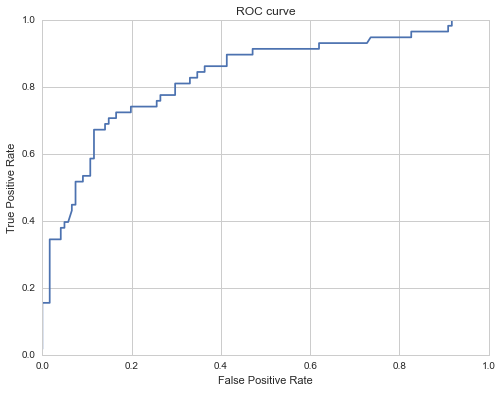

In [17]:
prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= roc_curve(y_test, prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, prob)
area = auc(recall, precision)
print "Area Under Curve: {0:.3f}".format(area)

Area Under Curve: 0.737
